In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from matplotlib import style

plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['red'])

In [2]:
df = pd.read_csv('./BankChurners.csv')
df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], inplace=True)
df['Attrition_Flag'].mask(df['Attrition_Flag'] == 'Existing Customer', 1, inplace=True)
df['Attrition_Flag'].mask(df['Attrition_Flag'] == 'Attrited Customer', 0, inplace=True)
df['Attrition_Flag'] = df['Attrition_Flag'].astype(int)
print(df.isna().sum())

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64


In [3]:
df.dtypes

CLIENTNUM                     int64
Attrition_Flag                int32
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

In [4]:
#defining and splitting variables
X = df.drop(columns=['CLIENTNUM', 'Attrition_Flag'])
y = df['Attrition_Flag']

idx_train, idx_test = train_test_split(X.index, stratify=y, random_state=123)

X_train, X_test = X.loc[idx_train], X.loc[idx_test]
y_train, y_test = y[idx_train], y[idx_test]

In [5]:
#checking proportions of zeros in train and val set (I want to ensure proportions are equal (or almost equal))

count = (y_train == 0).sum()
print('Percent of zeros in y train : ', count/len(y_train))
count = (y_test == 0).sum()
print('Percent of zeros in y val : ', count/len(y_test))

Percent of zeros in y train :  0.16063199473337722
Percent of zeros in y val :  0.16074249605055294


In [6]:
#selecting numerical and categorical columns

numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X_train.select_dtypes(include='object').columns


In [7]:
#listing classifiers, scalers and transformers that should be compared

classifiers = [
    DummyClassifier(strategy='stratified'),
    LogisticRegression(max_iter=500), 
    KNeighborsClassifier(2), 
    ExtraTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    XGBClassifier(),
    CatBoostClassifier(silent=True),
    LGBMClassifier(verbose=-1)
]

scalers = [StandardScaler(), MinMaxScaler(feature_range=(0,1)), Normalizer()]

categorical_transformers = [OrdinalEncoder(), OneHotEncoder()]

In [8]:
transformer_numerical = Pipeline(steps = [
    ('num_trans', MinMaxScaler(feature_range=(0,1)))
])

transformer_categorical = Pipeline(steps = [
    ('cat_trans', OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers = [
    ('numerical', transformer_numerical, numerical_columns),
    ('categorical', transformer_categorical, categorical_columns)
])

In [9]:
#empty dataframe for model evaluation parameters
models_df = pd.DataFrame()

#preparing pipeline
pipe = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', None)
])

#ignoring warnings(append will not be supported in the future[used at the end of current cell])
import warnings
warnings.filterwarnings("ignore")

#changing params for each model
for model in classifiers:
    for num_tr in scalers:
        for cat_tr in categorical_transformers:
            pipe_params = {
                'preprocessor__numerical__num_trans': num_tr,
                'preprocessor__categorical__cat_trans': cat_tr,
                'classifier': model
            }
            pipe.set_params(**pipe_params)

            start_time = time.time()
            pipe.fit(X_train, y_train)   
            end_time = time.time()

            score = pipe.score(X_test, y_test)
            y_pred = pipe.predict(X_test)
            try:
                auc = roc_auc_score(y_pred, y_test)
            except:
                auc = None

            param_dict = {
                        'model': model.__class__.__name__,
                        'num_trans': num_tr.__class__.__name__,
                        'cat_trans': cat_tr.__class__.__name__,
                        'score': auc,
                        'time_elapsed': end_time - start_time
            }

            models_df = models_df.append(pd.DataFrame(param_dict, index=[0]))


In [10]:
models_df[['model', 'score', 'time_elapsed']] .groupby('model') .aggregate({
        'score': ['mean','std', 'min', 'max'],
        'time_elapsed': ['mean','std', 'min', 'max']
        }).reset_index().sort_values(('score', 'mean'), ascending=False)

model     score                                \
                               mean       std       min       max   
0      CatBoostClassifier  0.950939  0.017161  0.926402  0.963012   
8           XGBClassifier  0.943047  0.023190  0.911494  0.958427   
4          LGBMClassifier  0.939325  0.025300  0.901236  0.957257   
6  RandomForestClassifier  0.928506  0.022205  0.894679  0.947418   
7                     SVC  0.897243  0.005760  0.890495  0.902768   
5      LogisticRegression  0.869408  0.029356  0.846769  0.919795   
2     ExtraTreeClassifier  0.759253  0.033516  0.707019  0.810804   
3    KNeighborsClassifier  0.665784  0.086494  0.579780  0.778057   
1         DummyClassifier  0.498609  0.002913  0.493973  0.502358   

  time_elapsed                                
          mean       std       min       max  
0     5.867822  0.396769  5.473911  6.469804  
8     0.768406  0.308459  0.484198  1.196277  
4     0.258252  0.036855  0.207097  0.300853  
6     1.758253  0.578557  1.321578  2.671962  
7     1.251990  0.438815  0.739025  1.852638  
5     0.116727  0.038294  0.053395  0.168083  
2     0.025355  0.002830  0.022000  0.028503  
3     0.016647  0.002582  0.013749  0.019726  
1     0.027280  0.006433  0.016361  0.034999

In [11]:
models_df.sort_values('score', ascending=False)

,model,num_trans,cat_trans,score,time_elapsed
0,CatBoostClassifier,StandardScaler,OrdinalEncoder,0.963012,5.650309
0,CatBoostClassifier,MinMaxScaler,OrdinalEncoder,0.963012,5.473911
0,CatBoostClassifier,StandardScaler,OneHotEncoder,0.960890,5.643039
0,CatBoostClassifier,MinMaxScaler,OneHotEncoder,0.960890,5.716320
0,XGBClassifier,StandardScaler,OrdinalEncoder,0.958427,0.484198
0,XGBClassifier,MinMaxScaler,OrdinalEncoder,0.958427,0.536606
0,XGBClassifier,StandardScaler,OneHotEncoder,0.957571,0.580430
0,XGBClassifier,MinMaxScaler,OneHotEncoder,0.957571,0.700669
0,LGBMClassifier,StandardScaler,OneHotEncoder,0.957257,0.300853
0,LGBMClassifier,MinMaxScaler,OneHotEncoder,0.956382,0.277188


From the table I choose CatBoostClassifier with MinMaxScaler and OneHotEncoder (score is the same as a score where standard scaler is used, but MinMaxScaler will be more 'safe' when it comes to test set evaluations).

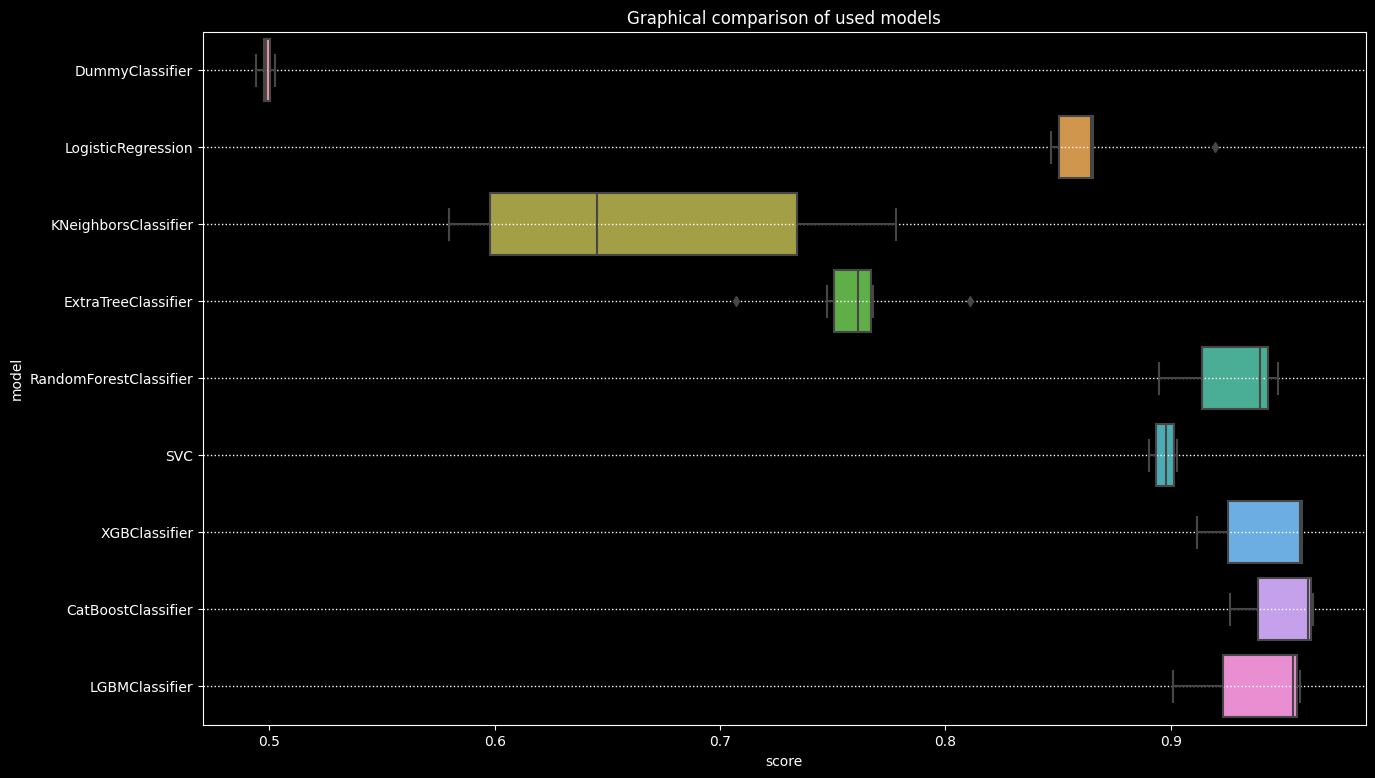

In [12]:
plt.figure(figsize=(15,9))
plt.title('Graphical comparison of used models')
sns.boxplot(data=models_df, x='score', y='model')
plt.grid(axis='y', linestyle='dotted', lw=1)
plt.show()

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

encoder = OneHotEncoder(sparse_output=False, handle_unknown="error", dtype=float).set_output(transform="pandas")

one_hot_encoded_train = encoder.fit_transform(X_train[categorical_columns])
one_hot_encoded_test = encoder.transform(X_test[categorical_columns])

X_train.drop(columns=categorical_columns, inplace=True)
X_test.drop(columns=categorical_columns, inplace=True)

X_train = pd.concat([X_train, one_hot_encoded_train], axis=1)
X_test = pd.concat([X_test, one_hot_encoded_test], axis=1)


In [14]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=999)
cv_results = cross_validate(CatBoostClassifier(verbose=False), X_train, y_train, scoring='roc_auc', cv=cv, return_train_score=True)

In [15]:
#checking discrepancy between train and validation results

print('Performance on a train set: ', cv_results['train_score']*100, '%')
print('Performance on a validation set: ', cv_results['test_score']*100, '%')
print('Differences: ', (cv_results['train_score']-cv_results['test_score'])*100, 'percentage points')

Performance on a train set:  [99.9907586  99.99258679 99.991964   99.99097959 99.9907586  99.99328994
 99.99230553 99.98931212 99.99347075 99.99063806 99.98933221 99.99047734
 99.99089923 99.99053761 99.99270733 99.9863388  99.99037689 99.99648425
 99.99312922 99.98842816 99.99150193 99.9937721  99.98923176 99.99146175
 99.99190373] %
Performance on a validation set:  [99.48698168 99.37608486 99.23497268 99.47476696 99.58405657 99.37512054
 99.00353584 99.46480231 99.46512375 99.45998071 99.47476696 99.41915783
 99.31115397 99.21568627 99.30568949 99.34104789 99.6187721  99.2648666
 99.44455159 99.31051109 99.36901318 99.43297975 99.35615558 99.30376085
 99.40790743] %
Differences:  [0.50377692 0.61650193 0.75699132 0.51621263 0.40670203 0.6181694
 0.98876969 0.5245098  0.52834699 0.53065734 0.51456525 0.57131951
 0.67974526 0.77485133 0.68701784 0.6452909  0.37160479 0.73161765
 0.54857763 0.67791707 0.62248875 0.56079235 0.63307618 0.6877009
 0.5839963 ] percentage points


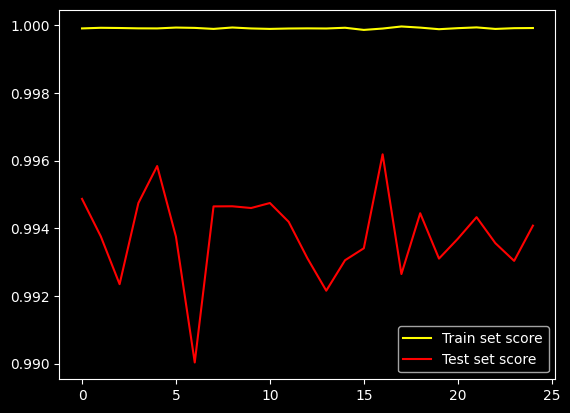

In [16]:
plt.plot(cv_results['train_score'], color='yellow', label='Train set score')
plt.plot(cv_results['test_score'], color='red', label='Test set score')
plt.legend()
plt.show()

In [17]:
y_pred = CatBoostClassifier(verbose=False).fit(X_train, y_train).predict(X_test)
print(f'ROC_AUC score: {roc_auc_score(y_pred, y_test)}')
print(f'F1 score: {f1_score(y_pred, y_test)}')
print(f'Precision: {precision_score(y_pred, y_test)}')
print(f'Recall: {recall_score(y_pred, y_test)}')
print(f'Accuracy: {accuracy_score(y_pred, y_test)}')

ROC_AUC score: 0.9608902005289824
F1 score: 0.98569082805536
Precision: 0.9887058823529412
Recall: 0.9826941066417212
Accuracy: 0.9759083728278041


To simplify, in this file I did only train-test split to choose the best algorithm.\
In Explanatory_Analysis-Interpreting file full train-validation-test split is done, there are also conclusions from the data and deeper view over relatioships.